# Deploying a model with Onepanel Inference API SDK

## Install requirements

Run the following command to install Onepanel SDK (if not in a Onepanel cluster) and other requirements.

In [ ]:
!pip install onepanel-sdk==1.0.1 requests pillow matplotlib

## Create required directory structure

In [ ]:
!mkdir images annotated
!curl -sL https://github.com/onepanelio/python-sdk/blob/master/resources/beach.jpg?raw=true -o images/beach.jpg

## Imports

In [2]:
import io
import os
import time
import base64
import json

from PIL import Image

import requests
import matplotlib.pyplot as plt


import onepanel.core.api
from onepanel.core.api.rest import ApiException
import onepanel.core.auth
from pprint import pprint

## Authentication

In [3]:
# If inside of a Onepanel cluster, parameters are not needed
access_token = onepanel.core.auth.get_access_token()

# Otherwise, pass in username, token and host
# access_token = onepanel.core.auth.get_access_token(username=, token=, host=)

# Configure API key authorization: Bearer
configuration = onepanel.core.api.Configuration(
    host=os.getenv('ONEPANEL_API_URL'),
    api_key={
        'authorization': access_token
    }
)
configuration.api_key_prefix['authorization'] = 'Bearer'

## Deploying a model

In [4]:
# Variables
namespace = 'demo'
model_name = 'sdk-deploy-example'

In [5]:
# Create inference API
with onepanel.core.api.ApiClient(configuration) as api_client:
    api_instance = onepanel.core.api.InferenceServiceApi(api_client)
    
    predictor_params = {
        'name': 'tensorflow',
        'storage_uri': 's3://demo/models/rcnn',
        'runtime_version': '2.5.1',
        'node_selector': 'Standard_D4s_v3',
    }
    predictor = onepanel.core.api.InferenceServicePredictor(**predictor_params)
    body = onepanel.core.api.CreateInferenceServiceRequest(name=model_name, predictor=predictor, default_transformer_image='onepanel/transformer-tfod-base64:v1.0.0')
    
    
    try:
        api_response = api_instance.create_inference_service(namespace, body)
        pprint(api_response)
    except ApiException as e:
        print('Exception when calling InferenceServiceApi->create_inference_service: %s\n' % e)

{'conditions': [], 'predict_url': '', 'ready': False}


In [6]:
# Get status of inference API
with onepanel.core.api.ApiClient(configuration) as api_client:
    api_instance = onepanel.core.api.InferenceServiceApi(api_client)

    try:
        ready = False
        while not ready:
            api_response = api_instance.get_inference_service(namespace, model_name)
            ready = api_response.ready
            endpoint = api_response.predict_url
            time.sleep(1)
    except ApiException as e:
        print('Exception when calling InferenceServiceApi->get_inference_service_status: %s\n' % e)
        
pprint(api_response)

{'conditions': [{'last_transition_time': '2021-08-13T22:53:56Z',
                 'status': 'True',
                 'type': 'IngressReady'},
                {'last_transition_time': '2021-08-13T22:53:51Z',
                 'status': 'True',
                 'type': 'PredictorConfigurationReady'},
                {'last_transition_time': '2021-08-13T22:53:51Z',
                 'status': 'True',
                 'type': 'PredictorReady'},
                {'last_transition_time': '2021-08-13T22:50:24Z',
                 'status': 'True',
                 'type': 'PredictorRouteReady'},
                {'last_transition_time': '2021-08-13T22:53:56Z',
                 'status': 'True',
                 'type': 'Ready'},
                {'last_transition_time': '2021-08-13T22:53:56Z',
                 'status': 'True',
                 'type': 'TransformerConfigurationeReady'},
                {'last_transition_time': '2021-08-13T22:53:56Z',
                 'status': 'True',
             

## Detect objects using Inference API

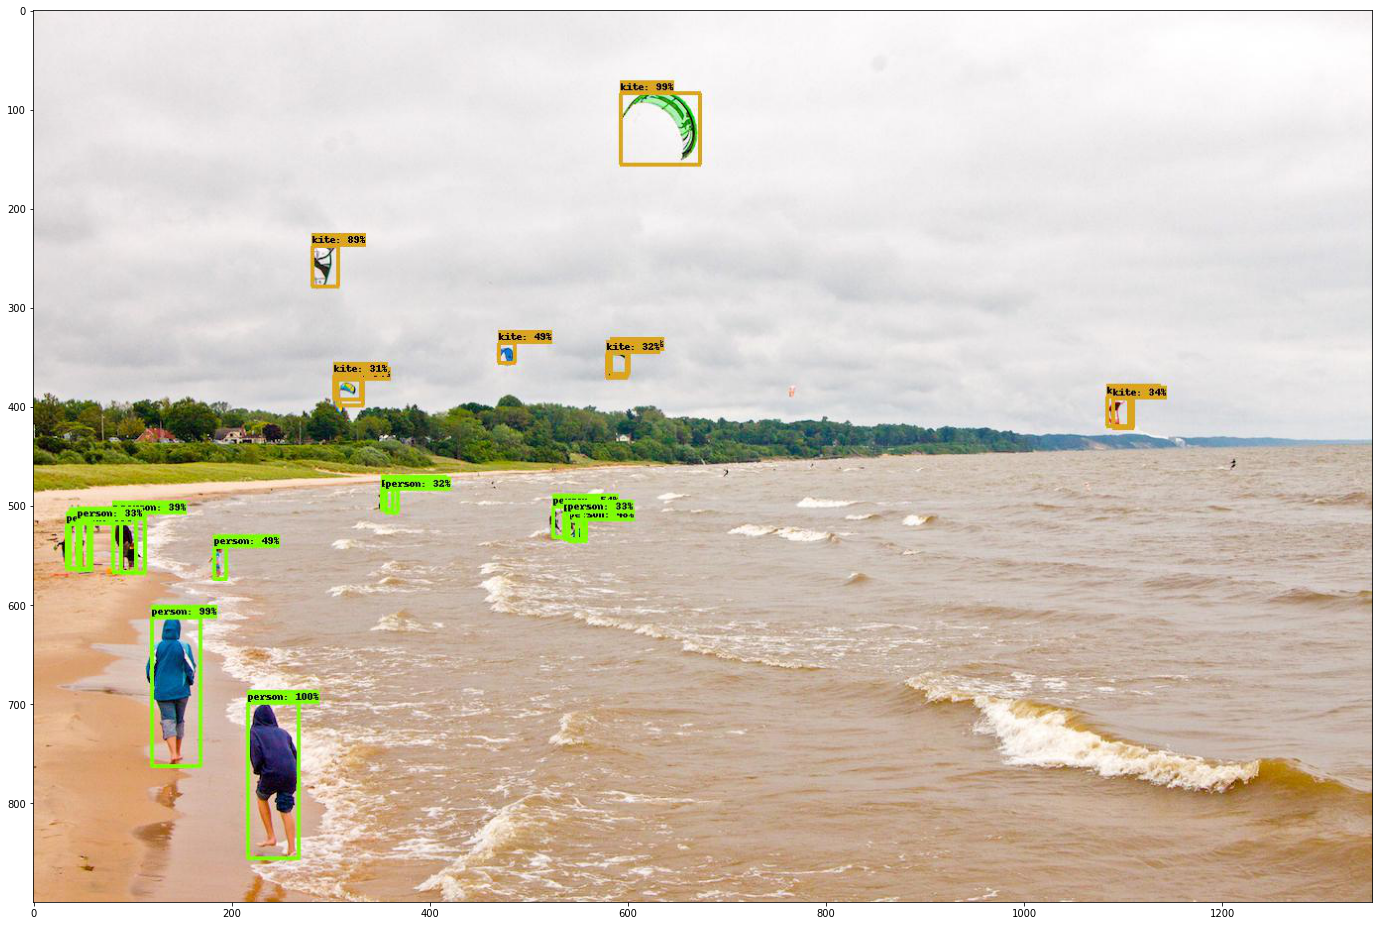

In [7]:
def image_to_base64str(img_path, format='JPEG'):
    image = Image.open(img_path)
    buffer = io.BytesIO()
    image.save(buffer, format=format)
    myimage = buffer.getvalue()
    
    return base64.b64encode(myimage).decode()

input_image_path = './images/beach.jpg'
output_image_path = './annotated/beach_annotated.jpg'

image_str = image_to_base64str(input_image_path)

data = {
    'instances': [{'data': image_str}]
}


headers = {
    'onepanel-access-token': access_token
}

r = requests.post(endpoint, headers=headers, json=data)

base64img = r.json()['image']

imgdata = base64.b64decode(base64img)
with open(output_image_path, 'wb') as f:
    f.write(imgdata)

image = Image.open(io.BytesIO(imgdata))

plt.figure(figsize=(24,32))
plt.imshow(image)
plt.show()